In [9]:
pwd

'/mmfs1/data/liacz/Documents/Bilingualism_CVAE/script/CVAE_notebook'

In [10]:
!module load cudnn8.1-cuda11.2/8.1.1.33

In [11]:
!module list

Currently Loaded Modulefiles:
 1) slurm/slurm/current   5) cuda11.2/toolkit/11.2.2     
 2) slurmExtras/1.0       6) cudnn8.1-cuda11.2/8.1.1.33  
 3) gcc/9.2.0             7) anaconda/2020.07-p3.8       
 4) cuda-dcgm/2.2.9.1    
>

In [12]:
!nvidia-smi

Sun Oct  2 13:12:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   39C    P0    76W / 300W |  16155MiB / 16160MiB |     97%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [13]:
from datetime import datetime;now = datetime.now;t00 = now()
print(t00)

2022-10-02 13:13:03.786644


In [14]:
# GPU checks
import tensorflow as tf
# tf.test.gpu_device_name()
# tf.test.is_gpu_available()
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
import timeit,pickle
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

NotFoundError: Exception encountered when calling layer "conv2d_5" "                 f"(type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 536334016 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 536334016 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 442780032 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 442780032 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 47659008 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 47659008 bytes. [Op:Conv2D]

Call arguments received by layer "conv2d_5" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(100, 100, 100, 3), dtype=float32)

In [2]:
%matplotlib inline

from importlib import reload
from helper_funcs import *
from make_models2 import *

# Make tqdm work for notebooks
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import pickle
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform


print(now()-t00)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/public/anaconda/2020.07-p3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-9c1356bc5697>", line 5, in <module>
    from make_models2 import *
  File "/mmfs1/data/liacz/Documents/Bilingualism_CVAE/script/CVAE_notebook/make_models2.py", line 1, in <module>
    import tensorflow as tf
  File "/mmfs1/data/liacz/.local/lib/python3.8/site-packages/tensorflow/__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/mmfs1/data/liacz/.local/lib/python3.8/site-packages/tensorflow/python/__init__.py", line 45, in <module>
    from tensorflow.python.feature_column import feature_column_lib as feature_column
  File "/mmfs1/data/liacz/.local/lib/python3.8/site-packages/tensorflow/python/feature_column/feature_column_lib.py", line 18, in <module>
    from tensorflow.python.feature_c

TypeError: object of type 'NoneType' has no len()

In [7]:
import numpy as np
import pandas as pd
import os
indir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/array_brains'
ABIDE_data = np.empty([0,64,64,64])
ABIDE_subs = np.empty([0,])
for dat in os.listdir(indir): 
    if dat.startswith('Anat'):
        arr = np.load(os.path.join(indir,dat))
        ABIDE_data = np.concatenate((ABIDE_data, arr['data']), axis=0)
        ABIDE_subs = np.concatenate((ABIDE_subs, arr['subs']), axis=0)

In [8]:
np.save(os.path.join(indir, ("arr_combine/ABIDE_data")), ABIDE_data)
np.save(os.path.join(indir, ("arr_combine/ABIDE_subs")), ABIDE_subs)

In [10]:
ABIDE_data = np.array(ABIDE_data)
nsubs = ABIDE_data.shape[0]
print([arr.shape for arr in [ABIDE_subs,ABIDE_data]])
print(nsubs)
print((ABIDE_data.min(),ABIDE_data.max()))

[(155,), (155, 64, 64, 64)]
155
(0.0, 1.0)


In [11]:
df = pd.read_csv('/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/ABIDE_legend.csv')
BI_subs = df.loc[(df['bilingualism'].values == 1), 'participant_id']
BI_subs = [sub for sub in BI_subs]
MO_subs = df.loc[(df['bilingualism'].values == 0), 'participant_id']
MO_subs = [sub for sub in MO_subs]
ABIDE_subs = [int(sub.split('-')[1]) for sub in ABIDE_subs]
BI_subs = [sub in BI_subs for sub in ABIDE_subs]
MO_subs = [sub in MO_subs for sub in ABIDE_subs]

In [12]:
#random assign for pilot
TD_subs = ABIDE_data[MO_subs,:,:,:] # Data of Monolinguals 
DX_subs = ABIDE_data[BI_subs,:,:,:] # Data of Bilinguals

print(TD_subs.shape)
print(DX_subs.shape)

(33, 64, 64, 64)
(122, 64, 64, 64)


# train VAE

In [13]:
train_vae = True

In [14]:
if train_vae:
    
    latent_dim = 32
    batch_size = 16
    disentangle = False
    gamma = 100

    encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64,64,64,1), 
                                            latent_dim=32, 
                                            batch_size = batch_size, 
                                            disentangle=True,
                                            gamma=gamma,
                                            kernel_size = 3,
                                            filters = 48,
                                            intermediate_dim = 128,
                                            nlayers = 2,
                                            bias=True)


    loss = list()
    fn = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/VAE/VAE_weights'
        
    print(fn)

/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/VAE/VAE_weights


In [15]:
encoder.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 encoder_input (InputLayer)      [(None, 64, 64, 64,   0           []                               
                                 1)]                                                                
                                                                                                    
 conv3d (Conv3D)                 (None, 32, 32, 32, 9  2688        ['encoder_input[0][0]']          
                                 6)                                                                 
                                                                                                    
 conv3d_1 (Conv3D)               (None, 16, 16, 16, 1  497856      ['conv3d[0][0]']                 
                                 92)                                      

In [16]:
decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 z_sampling (InputLayer)                     [(None, 32)]                            0              
                                                                                                    
 dense_1 (Dense)                             (None, 128)                             4224           
                                                                                                    
 dense_2 (Dense)                             (None, 786432)                          101449728      
                                                                                                    
 reshape (Reshape)                           (None, 16, 16, 16, 192)                 0              
                                                                          

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

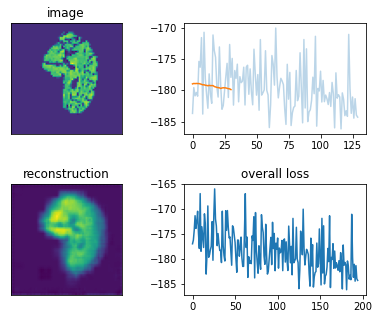

 98%|█████████▊| 195/199 [03:07<00:03,  1.06it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 196/199 [03:08<00:02,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 197/199 [03:08<00:01,  1.22it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 198/199 [03:09<00:00,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 199/199 [03:10<00:00,  1.05it/s]


In [30]:
nbatches = 200
if train_vae:
    for i in tqdm(range(1,nbatches)):    
        
        batch_idx = np.random.randint(low=0,high=ABIDE_data.shape[0],size=batch_size)
        data_batch = ABIDE_data[batch_idx,:,:,:]
        
        history = vae.train_on_batch(data_batch);
        mse = ((data_batch-vae.predict(data_batch)[:,:,:,:,0])**2).mean()
        loss.append(history);
        
        if np.mod(i,5)==0: # Plot training progress
            im1 = data_batch[0,32,:,:];
            im = vae.predict(data_batch)[0,32,:,:,0];
            plot_trainProgress(loss,im,im1);

        if np.mod(i,10)==0: # Save every 100 batches
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            vae.save_weights(fn)    
        
        if mse < .005:
            break

# train CVAE

In [32]:
train_cvae = True

In [33]:
if train_cvae:
    
    latent_dim = 16
    batch_size = 16
    beta = 1;gamma = 100
    disentangle = True
    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
    loss = list()    
    
    fdir = '/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/CVAE/'
    fn = 'CVAE_weights'
    
    fn = os.path.join(fdir,fn)
    loss = []

In [34]:
print(fn)

/mmfs1/data/liacz/Documents/Bilingualism_CVAE/data/tf_outputs/CVAE/CVAE_weights


In [35]:
z_encoder.summary(line_length=100)

Model: "z_encoder"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 tg_inputs (InputLayer)          [(None, 64, 64, 64,   0           []                               
                                 1)]                                                                
                                                                                                    
 conv3d_10 (Conv3D)              (None, 32, 32, 32, 6  1792        ['tg_inputs[0][0]']              
                                 4)                                                                 
                                                                                                    
 conv3d_11 (Conv3D)              (None, 16, 16, 16, 1  221312      ['conv3d_10[0][0]']              
                                 28)                                    

In [36]:
cvae_decoder.summary(line_length=100)

Model: "decoder"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 z_sampling (InputLayer)                     [(None, 32)]                            0              
                                                                                                    
 dense_16 (Dense)                            (None, 128)                             4224           
                                                                                                    
 dense_17 (Dense)                            (None, 524288)                          67633152       
                                                                                                    
 reshape_3 (Reshape)                         (None, 16, 16, 16, 128)                 0              
                                                                          

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

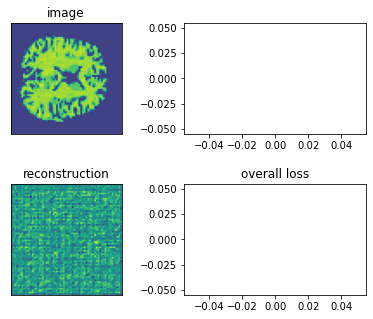

In [37]:
DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];

if len(loss)==0:
    loss.append(np.nan)
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);
    loss = list()
else:
    im,im1,ss = cvae_query(ABIDE_data,s_encoder,z_encoder,cvae_decoder);
    plot_trainProgress(loss,im,im1);

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

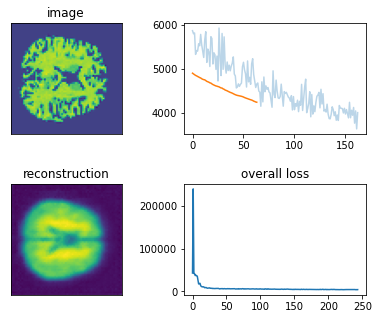

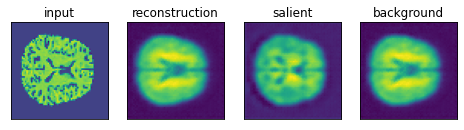

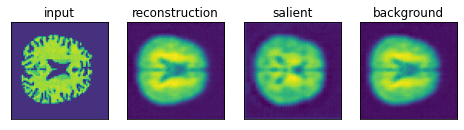

 92%|█████████▏| 45/49 [00:57<00:05,  1.26s/it]

2/2 [==============================] - 0s 48ms/step


 94%|█████████▍| 46/49 [00:58<00:03,  1.16s/it]

2/2 [==============================] - 0s 47ms/step


 96%|█████████▌| 47/49 [00:59<00:02,  1.10s/it]

2/2 [==============================] - 0s 47ms/step


 98%|█████████▊| 48/49 [01:00<00:01,  1.05s/it]

2/2 [==============================] - 0s 48ms/step


100%|██████████| 49/49 [01:01<00:00,  1.25s/it]


In [39]:
nbatches = 50
if train_cvae:
    for i in tqdm(range(1,nbatches)):
        
        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
        hist = cvae.train_on_batch([DX_batch,TD_batch]);
        loss.append(hist);
        
        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

        assert not np.isnan(hist),'loss is NaN - somethings wrong'

        im,im1,ss = cvae_query(ABIDE_data, s_encoder, z_encoder, cvae_decoder); 

        

        if np.mod(i,5)==0: # Plot training progress
            plot_trainProgress(loss,im,im1);
            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

        if np.mod(i,10)==0: # Save every 10 batches
            cvae.save_weights(fn)
            
        if mse < .005:
            break